# Training Model MERA
This notebook demonstrates a variational circuit structured in a Multi-scale Entanglement Renormalization Ansatz (MERA). We present a multi-class quantum classifier inspired by the articles [Optimal Quantum Circuits for General Two-Qubit Gates
Farrokh Vatan, Colin Williams](https://arxiv.org/abs/quant-ph/0308006) and ["Multi-class quantum classifiers with tensor network circuits for quantum phase recognition"](https://arxiv.org/abs/2110.08386). The circuit is constructed using $SU(4)# and #SU(2)# elements. We employ the MERA template to broadcast the input circuit across multiple wires, following the architecture of a MERA tensor network, based on the framework described in "A class of quantum many-body states that can be efficiently simulated," and drawing parallels with Quantum Convolutional Neural Networks.

We're utilizing PCA for dimensionality reduction. In the future, it would be beneficial to further explore this architecture by tuning hyperparameters, experimenting with different cost functions, and considering alternative dimensionality reduction techniques.

We initially used only the `cross-entropy` cost function, but the code is designed to easily switch to other cost functions, such as the `average exponential` cost function or the `average focal` cost function, both of which are available in the 'training.py' file.
<a id="0"></a> <br>
1. [Data Preparation](#1)
2. [Model](#2)
3. [Experiment 1](#3)
    a. [Training](#4)
    b. [Test Accuracy](#5)
4. [Experiment 2](#6)
    a. [Training](#7)
    b. [Test Accuracy](#8)
4. [Experiment 3](#9)
    a. [Training](#10)
    b. [Test Accuracy](#11)
5. [Experiment 4](#12)
    a. [Training](#13)
    b. [Test Accuracy](#14)
5. [Experiment 5](#15)
 


| Experiment | Training set         | Validation set       | Test set             | Cost function      | Epoch | Batch | Learning rate | Training time | Val_accuracy | Test_accuracy |
|------------|-----------------------|----------------------|----------------------|--------------------|-------|-------|----------------|---------------|--------------|---------------|
| 1          | [349 364 350 350 325 361] | [61 42 39 51 61 47]  | [90 94 111 99 114 92] | Cross-Entropy Loss | 70    | 64    | 0.05           | 0.5 h         | 56.81%       | 47.16%        |
| 2          | [349 364 350 350 325 361] | [61 42 39 51 61 47]  | [90 94 111 99 114 92] | Cross-Entropy Loss | 100   | 128   | 0.01           | 1 h           | 46.18%       | 42.5%          |
| 3          | [349 364 350 350 325 361] | [61 42 39 51 61 47]  | [90 94 111 99 114 92] | Cross-Entropy Loss | 215   | 32    | 0.01           | 1.5 h         | 48.18%       | 42.66%        |
| 4          | [692 688 710 702 716 691] | [93 113 107 100 87 101] | [215 199 183 198 197 208] | Cross-Entropy Loss | 300   | 64    | 0.05           | 7.5 h         | 59,9%          | 57%           |


<a id="1"></a>
### Data Preparation

In [1]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader(
    json_paths=['./Data_Sources/al5083/train/train.json', './Data_Sources/al5083/test/test.json'],
    data_dirs=['./Data_Sources/al5083/train', './Data_Sources/al5083/test'],
    image_size=(64, 64)
)

In [2]:
all_data = loader.load_images(image_limit=500,vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75)

Images loaded: 3000, Current label: 5, Total per label: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500}

Total images loaded : 3000


Shuffles the dataset and separates it into flattened features and labels. Applies PCA to reduce the dimensionality of the given dataset to components = `256`

In [3]:
import Modules.Utils
X_set,Y_set = Modules.Utils.prepare_data(all_data)
X_reduced = Modules.Utils.apply_pca(X_set, n_components=256)

Split train data to train set and validation set. `train_ratio=0.7`

In [5]:
from Modules.Utils import split_data_into_train_val_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data_into_train_val_test(X_reduced, Y_set, train_ratio=0.7, val_ratio=0.1,test_ratio=0.2)

Y_train: Values: [0 1 2 3 4 5] Counts: [332 351 340 356 369 351]
Y_val: Values: [0 1 2 3 4 5] Counts: [58 46 50 57 42 48]
Y_test: Values: [0 1 2 3 4 5] Counts: [110 103 110  87  89 101]


<a id="2"></a>
### Model

Quantum circuits is constructed by using $SU(4)$ using elements of $SU(2)$ [Optimal Quantum Circuits for General Two-Qubit Gates](https://arxiv.org/abs/quant-ph/0308006)

Simple unitary with general rotations
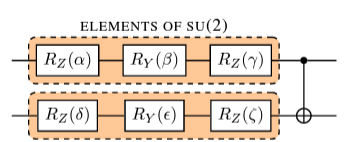

General element of $SU(4)$. A,B,C,D are elements of $SU(2)$.
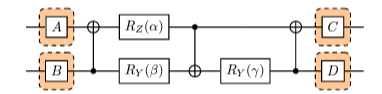
Source: [Multi-class quantum classifiers with tensor network circuits for quantum phase recognition](https://arxiv.org/abs/2110.08386)

Su(2) we can implemented by 1qml.Rot`.

(<Figure size 1400x300 with 1 Axes>, <Axes: >)

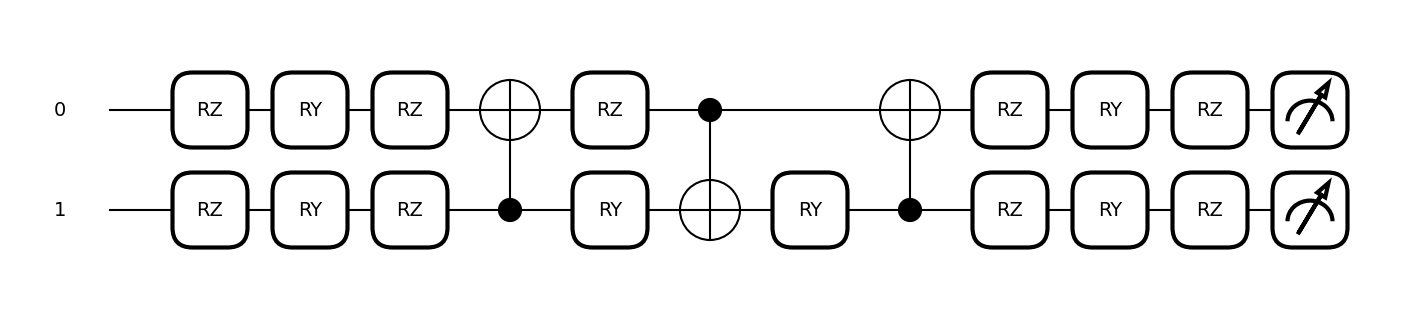

In [10]:
import pennylane as qml
from pennylane import numpy as np
def block(weights, wires):
    qml.Rot(weights[0],weights[1],weights[2],wires=wires[0])
    qml.Rot(weights[3],weights[4],weights[5],wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RZ(weights[6], wires=wires[0])

    qml.RY(weights[7], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(weights[8], wires=wires[1])

    qml.CNOT(wires=[wires[1], wires[0]])
    qml.Rot(weights[9],weights[10],weights[11],wires=wires[0])
    qml.Rot(weights[12],weights[13],weights[14],wires=wires[1])

dev= qml.device('default.qubit',wires=range(2))
@qml.qnode(dev)
def circuit_block(f, template_weights):
    block(template_weights,wires=[0,1])
    return qml.probs(wires = [0, 1])

weights = np.random.random(size=[15, 1])
qml.draw_mpl(circuit_block, expansion_strategy="device")(X_train[0][0:4], weights)

We are utilizing the MERA template to broadcast an input circuit across multiple wires, following the architecture of a multi-scale entanglement renormalization ansatz (MERA) tensor network. This approach is based on the framework described in [A class of quantum many-body states that can be efficiently simulated](arXiv:quant-ph/06100990) and shares similarities with [Quantum Convolutional Neural Networks](https://arxiv.org/abs/1810.03787).

(<Figure size 9600x900 with 1 Axes>, <Axes: >)

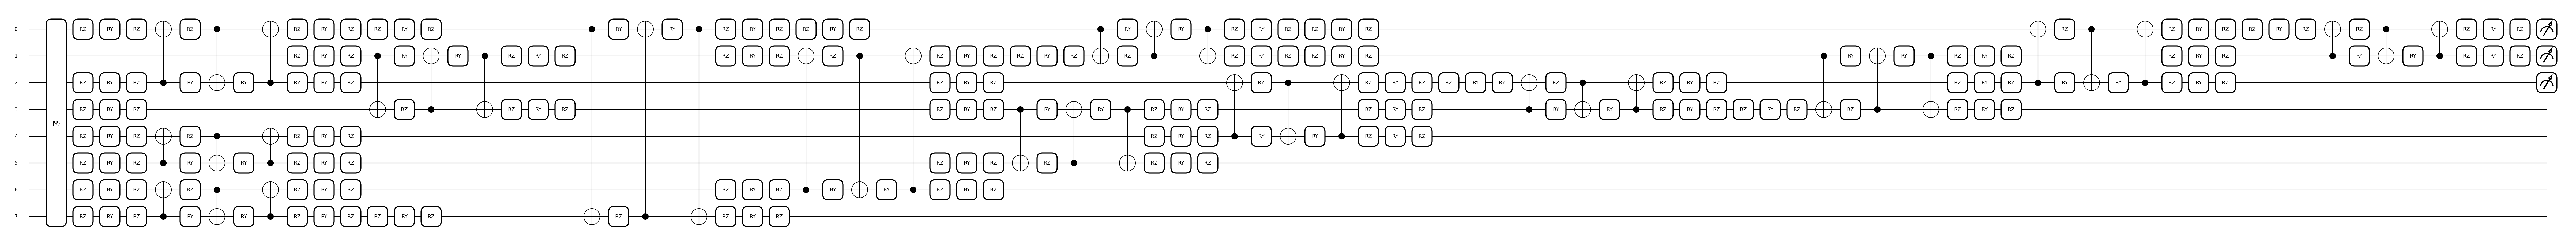

In [11]:
n_wires = 8
n_block_wires = 2
n_params_block = 15
n_blocks = qml.MERA.get_n_blocks(range(n_wires),n_block_wires)
template_weights = [[0.1,-0.3]]*n_blocks


dev= qml.device('default.qubit',wires=range(n_wires))
@qml.qnode(dev)
def circuit_MERA(f, template_weights):
    qml.AmplitudeEmbedding(features=f, wires=range(8), normalize=True)
    qml.MERA(range(n_wires),n_block_wires,block, n_params_block, template_weights)
    return qml.probs(wires = [0, 1, 2])


weights = np.random.random(size=[13, 15])
qml.draw_mpl(circuit_MERA, expansion_strategy="device")(X_train[0], weights)

<a id="3"></a>
### Experiments 1
<a id="4"></a>
#### Training
* Training set: [349 364 350 350 325 361]
* Validation set: [61 42 39 51 61 47]
* Test set: [ 90  94 111  99 114  92]
* Cost function: Cross-Entropy Loss
* Epoch: 70
* batch: 64
* learning rate:0.05
* val_accuracy: 56,81%

In [14]:
import math
from pennylane import numpy as np
def costfunc(params, X, Y):
    y_true = np.array([
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0]
    ])

    cost = 0
    len_X_set = len(X)

    for i in range(len_X_set):
        prob = circuit_MERA(X[i], params)
        cost -= 1 / len_X_set * np.sum(y_true[Y[i]] * np.log(prob))
    return cost

training the circuit parameters

In [65]:
# training the circuit parameters
from pennylane import numpy as np
x2 = np.random.random(size=[13, 15], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.05)
batch_size = 64
all_params = []
all_cost = []
all_accuracy = []

In [67]:
from Modules.metrices import accuracy

for k in range(70):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params = optimizer.step(costfunc, params, X=X_batch, Y=Y_batch)
    accuracy_value = accuracy(params,X_val,Y_val,circuit_MERA)
    cost = costfunc(params, X=X_batch, Y=Y_batch)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy.append(accuracy_value)
    all_cost.append(cost)
    all_params.append(params)
print(params)

Step 0| Cost: 1.8613101911333163 | Validation accuracy: 30.56%
Step 1| Cost: 1.8363816757080733 | Validation accuracy: 29.90%
Step 2| Cost: 1.8900971663421395 | Validation accuracy: 30.56%
Step 3| Cost: 1.7804177100126726 | Validation accuracy: 28.24%
Step 4| Cost: 1.788550610087993 | Validation accuracy: 30.23%
Step 5| Cost: 1.6838051158063303 | Validation accuracy: 36.21%
Step 6| Cost: 1.667063192887802 | Validation accuracy: 35.55%
Step 7| Cost: 1.6038584298282823 | Validation accuracy: 34.55%
Step 8| Cost: 1.7324114596761344 | Validation accuracy: 38.87%
Step 9| Cost: 1.739975631181099 | Validation accuracy: 39.87%
Step 10| Cost: 1.740937009183299 | Validation accuracy: 41.20%
Step 11| Cost: 1.7711696397082488 | Validation accuracy: 40.53%
Step 12| Cost: 1.7921748079225175 | Validation accuracy: 37.87%
Step 13| Cost: 1.7524612897635858 | Validation accuracy: 37.87%
Step 14| Cost: 1.7528698675439625 | Validation accuracy: 37.54%
Step 15| Cost: 1.7215467090268284 | Validation accurac

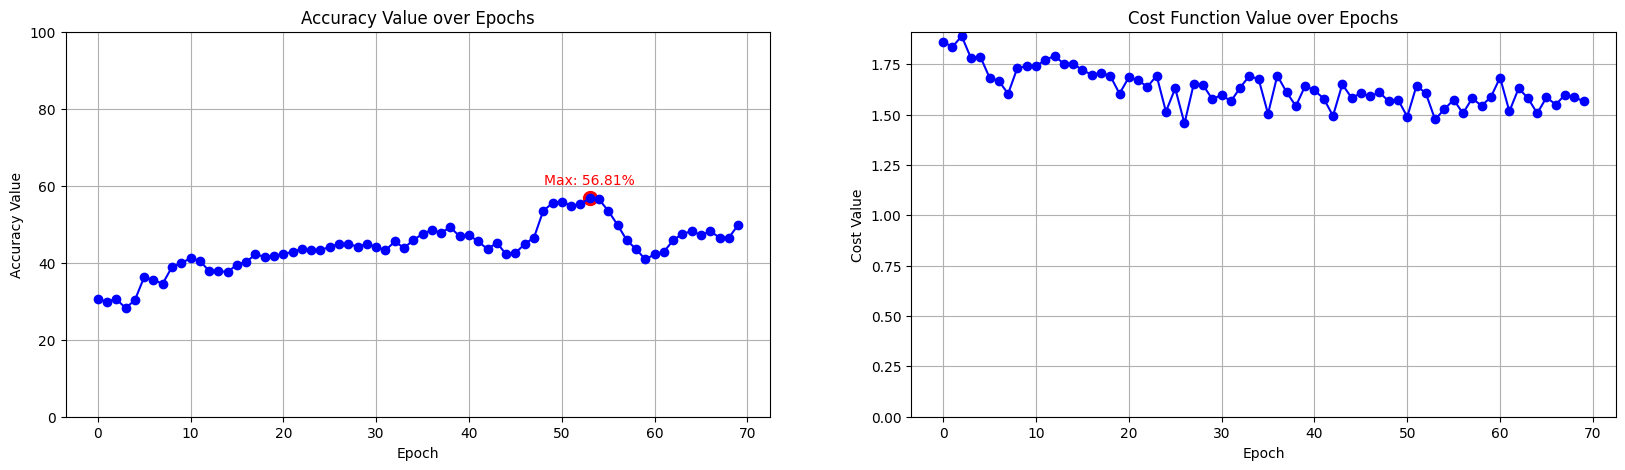

In [68]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy,all_cost)

<a id="5"></a>
### Accuracy
* test_accuracy: 47,16%

In [13]:
test_accuracy = accuracy(params,X_test,Y_test,circuit_MERA)

In [16]:
test_accuracy

47,16


<a id="6"></a>
### Experiments 2
<a id="7"></a>
#### Training
* Training set: [349 364 350 350 325 361]
* Validation set: [61 42 39 51 61 47]
* Test set: [ 90  94 111  99 114  92]
* Cost function: Cross-Entropy Loss
* Epoch: 100
* batch: 128
* learning rate:0.01
* val_accuracy: 46,18%

In [71]:
# training the circuit parameters
from pennylane import numpy as np
x2 = np.random.random(size=[13, 15], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.01)
batch_size = 128
all_params = []
all_cost = []
all_accuracy = []

In [72]:
from Modules.metrices import accuracy

for k in range(100):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params = optimizer.step(costfunc, params, X=X_batch, Y=Y_batch)
    accuracy_value = accuracy(params,X_val,Y_val,circuit_MERA)
    cost = costfunc(params, X=X_batch, Y=Y_batch)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy.append(accuracy_value)
    all_cost.append(cost)
    all_params.append(params)
print(params)

Step 0| Cost: 2.09405291137041 | Validation accuracy: 12.29%
Step 1| Cost: 2.065700525371619 | Validation accuracy: 13.95%
Step 2| Cost: 2.040688310153122 | Validation accuracy: 13.95%
Step 3| Cost: 2.0876881288238085 | Validation accuracy: 13.62%
Step 4| Cost: 2.0513913887802864 | Validation accuracy: 13.95%
Step 5| Cost: 2.0296554759642 | Validation accuracy: 13.62%
Step 6| Cost: 2.0830189577445126 | Validation accuracy: 13.95%
Step 7| Cost: 1.997881121057588 | Validation accuracy: 15.61%
Step 8| Cost: 1.9798737330756242 | Validation accuracy: 16.94%
Step 9| Cost: 1.9297405881386216 | Validation accuracy: 19.27%
Step 10| Cost: 1.9430875273471402 | Validation accuracy: 19.60%
Step 11| Cost: 1.9724879470025183 | Validation accuracy: 21.26%
Step 12| Cost: 1.9355155962939117 | Validation accuracy: 22.59%
Step 13| Cost: 1.8921985775192218 | Validation accuracy: 24.25%
Step 14| Cost: 1.9258498019011017 | Validation accuracy: 23.92%
Step 15| Cost: 1.8859212807897834 | Validation accuracy: 2

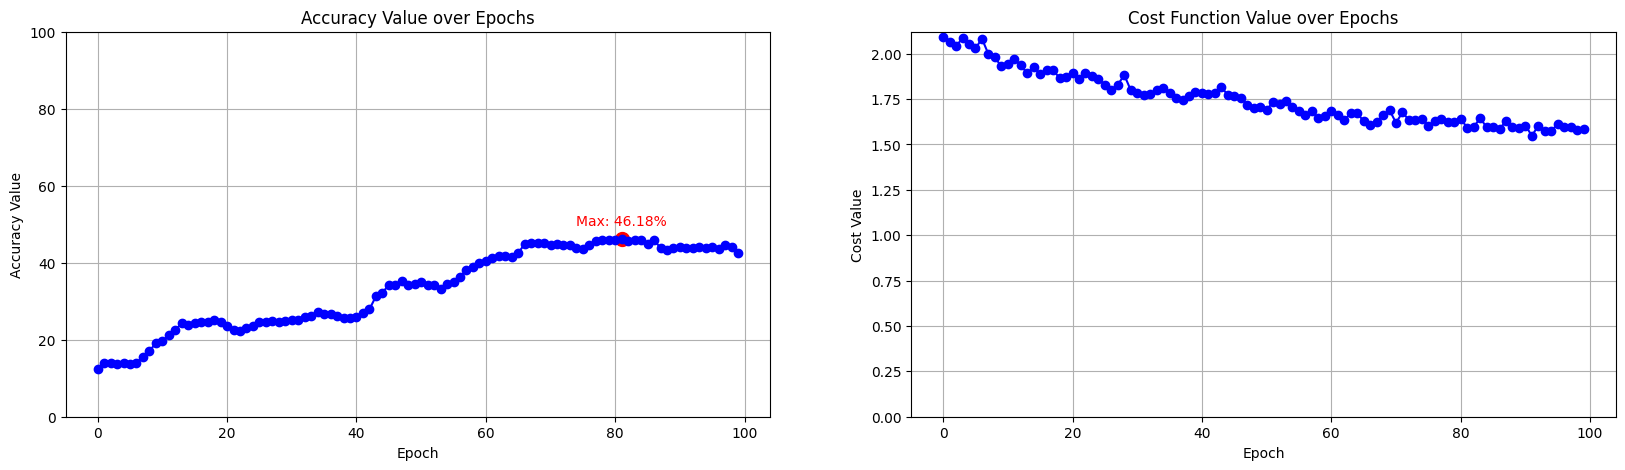

In [73]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy,all_cost)

<a id="8"></a>
### Accuracy
* test_accuracy: 42.5%

In [15]:
test_accuracy = accuracy(params,X_test,Y_test,circuit_MERA)

In [17]:
test_accuracy

42.5

<a id="9"></a>
### Experiments 3
<a id="10"></a>
#### Training
* Training set: [349 364 350 350 325 361]
* Validation set: [61 42 39 51 61 47]
* Test set: [ 90  94 111  99 114  92]
* Cost function: Cross-Entropy Loss
* Epoch: 215
* batch: 32
* learning rate:0.01

In [75]:
# training the circuit parameters
from pennylane import numpy as np
x2 = np.random.random(size=[13, 15], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.01)
batch_size = 32
all_params = []
all_cost = []
all_accuracy = []

In [87]:
from Modules.metrices import accuracy

for k in range(215):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params = optimizer.step(costfunc, params, X=X_batch, Y=Y_batch)
    accuracy_value = accuracy(params,X_val,Y_val,circuit_MERA)
    cost = costfunc(params, X=X_batch, Y=Y_batch)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy.append(accuracy_value)
    all_cost.append(cost)
    all_params.append(params)
print(params)

Step 0| Cost: 1.9817116569725235 | Validation accuracy: 23.59%
Step 1| Cost: 2.066850163289344 | Validation accuracy: 24.25%
Step 2| Cost: 1.8721894041059965 | Validation accuracy: 26.25%
Step 3| Cost: 1.8982398945740915 | Validation accuracy: 27.57%
Step 4| Cost: 1.9770940655316336 | Validation accuracy: 28.90%
Step 5| Cost: 1.9029139313741337 | Validation accuracy: 28.90%
Step 6| Cost: 1.830262357280526 | Validation accuracy: 26.58%
Step 7| Cost: 1.9051505538975955 | Validation accuracy: 26.91%
Step 8| Cost: 1.8594311920805322 | Validation accuracy: 26.25%
Step 9| Cost: 1.7673210908058163 | Validation accuracy: 26.91%
Step 10| Cost: 1.9165255974934954 | Validation accuracy: 29.57%
Step 11| Cost: 1.83100295622376 | Validation accuracy: 30.23%
Step 12| Cost: 1.8737865435971204 | Validation accuracy: 29.90%
Step 13| Cost: 1.8323742760122776 | Validation accuracy: 29.90%
Step 14| Cost: 1.7755601355749278 | Validation accuracy: 31.23%
Step 15| Cost: 1.7751784443400391 | Validation accurac

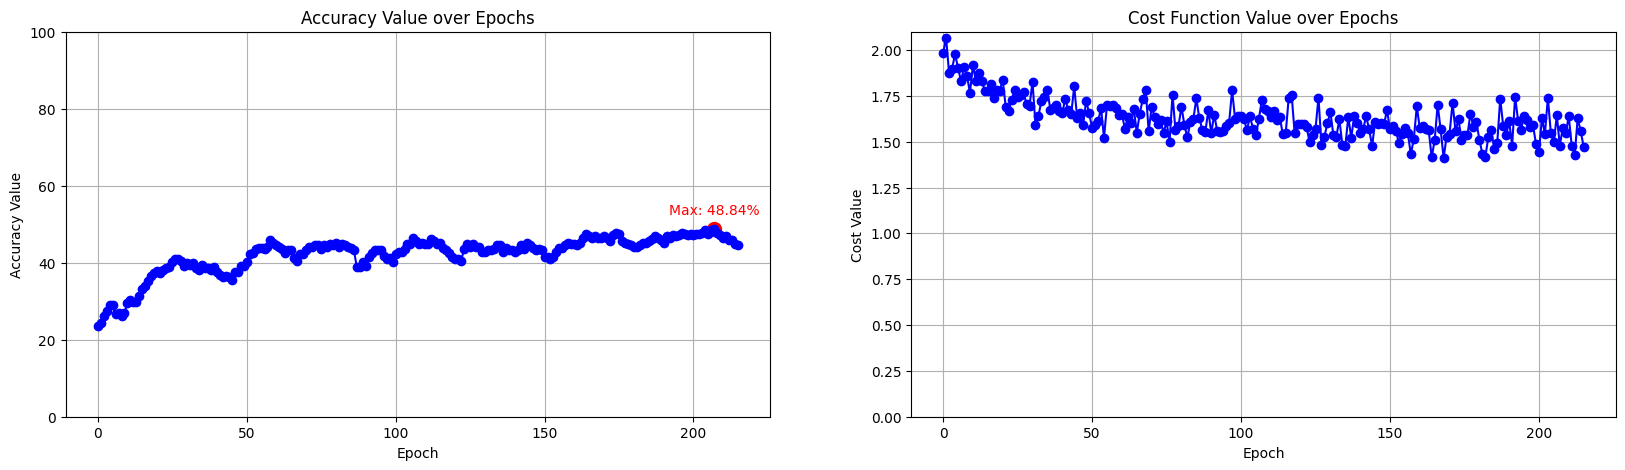

In [88]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy,all_cost)

<a id="11"></a>
### Accuracy
* test_accuracy: 42,66%

In [89]:
test_accuracy = accuracy(params,X_test,Y_test,circuit_MERA)

In [90]:
test_accuracy

42.666666666666664

<a id="12"></a>
### Experiments 4
<a id="13"></a>
#### Training
* Training set: [692 688 710 702 716 691]
* Validation set: [ 93 113 107 100  87 101]
* Test set: [215 199 183 198 197 208]
* Cost function: Cross-Entropy Loss
* Epoch: 300
* batch: 64
* learning rate:0.05
* training time: 7,5 h
* val_accuracy: 59,9%

* test_accuracy: 57%

In [6]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader(
    json_paths=['./Data_Sources/al5083/train/train.json', './Data_Sources/al5083/test/test.json'],
    data_dirs=['./Data_Sources/al5083/train', './Data_Sources/al5083/test'],
    image_size=(64, 64)
)

In [7]:
all_data = loader.load_images(image_limit=1000,vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75)

Images loaded: 6000, Current label: 5, Total per label: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000}

Total images loaded : 6000


In [8]:
import Modules.Utils
X_set,Y_set = Modules.Utils.prepare_data(all_data)

In [9]:
X_reduced = Modules.Utils.apply_pca(X_set, n_components=256)

In [10]:
from Modules.Utils import split_data_into_train_val_test

X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data_into_train_val_test(X_reduced, Y_set, train_ratio=0.7, val_ratio=0.1,test_ratio=0.2)

Y_train: Values: [0 1 2 3 4 5] Counts: [714 697 689 699 700 700]
Y_val: Values: [0 1 2 3 4 5] Counts: [ 89 116 101  96 108  91]
Y_test: Values: [0 1 2 3 4 5] Counts: [197 187 210 205 192 209]


In [101]:
# training the circuit parameters
from pennylane import numpy as np
x2 = np.random.random(size=[13, 15], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.05)
batch_size = 64
all_params = []
all_cost = []
all_accuracy = []

In [104]:
from Modules.metrices import accuracy

for k in range(300):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params = optimizer.step(costfunc, params, X=X_batch, Y=Y_batch)
    accuracy_value = accuracy(params,X_val,Y_val,circuit_MERA)
    cost = costfunc(params, X=X_batch, Y=Y_batch)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy.append(accuracy_value)
    all_cost.append(cost)
    all_params.append(params)
print(params)

Step 0| Cost: 1.8986067414122982 | Validation accuracy: 19.30%
Step 1| Cost: 1.9015647446789026 | Validation accuracy: 22.30%
Step 2| Cost: 1.889193190896778 | Validation accuracy: 26.29%
Step 3| Cost: 2.0089767345120433 | Validation accuracy: 26.96%
Step 4| Cost: 1.8704933473501262 | Validation accuracy: 29.62%
Step 5| Cost: 1.879909420291528 | Validation accuracy: 30.12%
Step 6| Cost: 1.7843225815155785 | Validation accuracy: 28.62%
Step 7| Cost: 1.7638730155506805 | Validation accuracy: 30.28%
Step 8| Cost: 1.8249117657124787 | Validation accuracy: 30.95%
Step 9| Cost: 1.7602671241805874 | Validation accuracy: 32.11%
Step 10| Cost: 1.8850108173172166 | Validation accuracy: 33.61%
Step 11| Cost: 1.750950211630568 | Validation accuracy: 35.61%
Step 12| Cost: 1.7323376163502981 | Validation accuracy: 34.44%
Step 13| Cost: 1.675090409006515 | Validation accuracy: 36.44%
Step 14| Cost: 1.7555806381462573 | Validation accuracy: 35.94%
Step 15| Cost: 1.7256841958315683 | Validation accurac

Step 129| Cost: 1.5399546148103895 | Validation accuracy: 54.08%
Step 130| Cost: 1.5104477284637707 | Validation accuracy: 52.75%
Step 131| Cost: 1.5339141049801348 | Validation accuracy: 51.08%
Step 132| Cost: 1.454424059263524 | Validation accuracy: 52.58%
Step 133| Cost: 1.482334655465446 | Validation accuracy: 54.58%
Step 134| Cost: 1.4279807578556345 | Validation accuracy: 56.74%
Step 135| Cost: 1.4806728241752969 | Validation accuracy: 57.40%
Step 136| Cost: 1.4135955457097622 | Validation accuracy: 57.74%
Step 137| Cost: 1.564231056724198 | Validation accuracy: 59.23%
Step 138| Cost: 1.4853496513118551 | Validation accuracy: 58.57%
Step 139| Cost: 1.4609407561670151 | Validation accuracy: 58.74%
Step 140| Cost: 1.4993782719659459 | Validation accuracy: 58.24%
Step 141| Cost: 1.4262899552730695 | Validation accuracy: 56.24%
Step 142| Cost: 1.5079338396466393 | Validation accuracy: 55.07%
Step 143| Cost: 1.544068798079427 | Validation accuracy: 55.07%
Step 144| Cost: 1.42757574790

Step 256| Cost: 1.4619871284204735 | Validation accuracy: 56.91%
Step 257| Cost: 1.37339701154266 | Validation accuracy: 54.91%
Step 258| Cost: 1.3826034039559703 | Validation accuracy: 54.08%
Step 259| Cost: 1.386037081792825 | Validation accuracy: 55.91%
Step 260| Cost: 1.4970780943884952 | Validation accuracy: 56.57%
Step 261| Cost: 1.5166034848126446 | Validation accuracy: 54.41%
Step 262| Cost: 1.468921754129481 | Validation accuracy: 51.58%
Step 263| Cost: 1.4725297791430376 | Validation accuracy: 51.08%
Step 264| Cost: 1.5333806982205191 | Validation accuracy: 54.08%
Step 265| Cost: 1.6321767623695265 | Validation accuracy: 55.07%
Step 266| Cost: 1.386619177491586 | Validation accuracy: 54.08%
Step 267| Cost: 1.4305873570209795 | Validation accuracy: 54.08%
Step 268| Cost: 1.4717041785449176 | Validation accuracy: 55.41%
Step 269| Cost: 1.4587914854508488 | Validation accuracy: 54.58%
Step 270| Cost: 1.428844435094483 | Validation accuracy: 52.75%
Step 271| Cost: 1.5186846822254

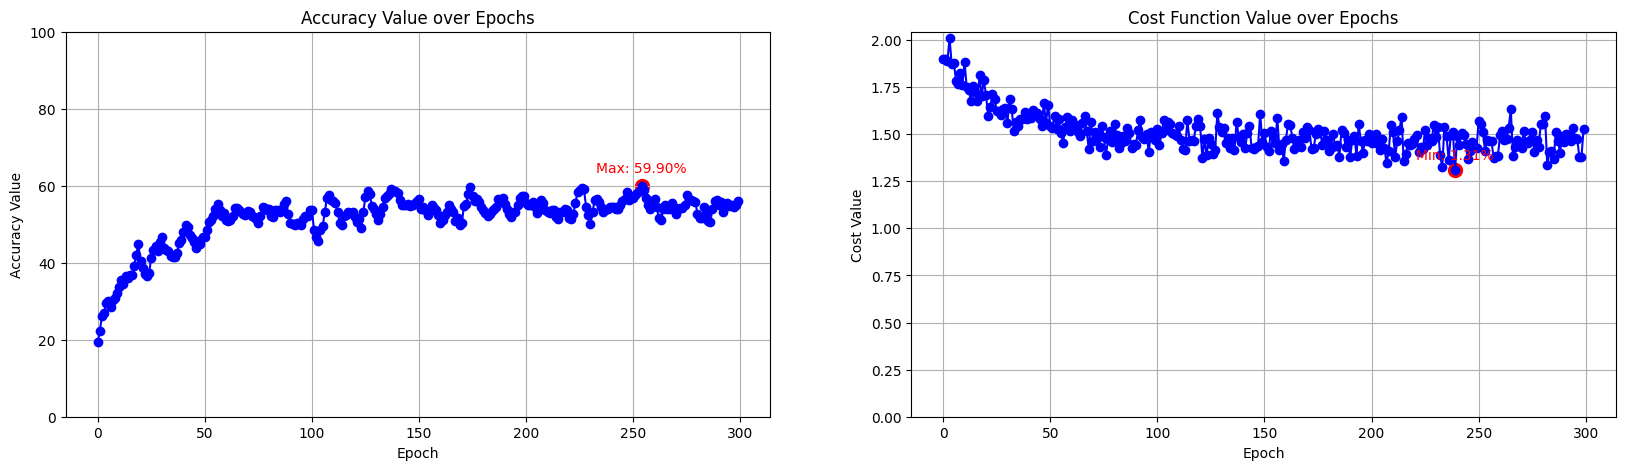

In [108]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy,all_cost)

<a id="14"></a>
### Accuracy
* test_accuracy: 57% 

In [109]:
test_accuracy = accuracy(params,X_test,Y_test,circuit_MERA)

In [110]:
test_accuracy

57.0

<a id="15"></a>
### Experiment 5


In [7]:
from Modules.ImageLoader import ImageLoader
loader = ImageLoader(
    json_paths=['./Data_Sources/al5083/train/train.json', './Data_Sources/al5083/test/test.json'],
    data_dirs=['./Data_Sources/al5083/train', './Data_Sources/al5083/test'],
    image_size=(64, 64)
)

In [8]:
all_data = loader.load_images(image_limit=1000,vertical_start_split=0.3, vertical_end_split=1.0,horizontal_start_split=0.25, horizontal_end_split=0.75)

Images loaded: 6000, Current label: 5, Total per label: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000}

Total images loaded : 6000


In [9]:
import Modules.Utils
from Modules.Utils import split_data_into_train_val_test

X_set,Y_set = Modules.Utils.prepare_data(all_data)
X_reduced = Modules.Utils.apply_pca(X_set, n_components=256)


X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data_into_train_val_test(X_reduced, Y_set, train_ratio=0.7, val_ratio=0.1,test_ratio=0.2)

In [16]:
# training the circuit parameters
from pennylane import numpy as np
x2 = np.random.random(size=[13, 15], requires_grad=True)
params = x2[:]
optimizer = qml.AdamOptimizer(stepsize=0.01)
batch_size = 64
all_params = []
all_cost = []
all_accuracy = []

In [ ]:
from Modules.metrices import accuracy

for k in range(1000):
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    params = optimizer.step(costfunc, params, X=X_batch, Y=Y_batch)
    accuracy_value = accuracy(params,X_val,Y_val,circuit_MERA)
    cost = costfunc(params, X=X_batch, Y=Y_batch)
    print(f"Step {k}| Cost: {cost} | Validation accuracy: {accuracy_value:.2f}%")

    all_accuracy.append(accuracy_value)
    all_cost.append(cost)
    all_params.append(params)
print(params)

Step 0| Cost: 1.9431733215260538 | Validation accuracy: 17.64%
Step 1| Cost: 2.0911152076562884 | Validation accuracy: 19.13%
Step 2| Cost: 1.9461019216526363 | Validation accuracy: 23.13%
Step 3| Cost: 1.9583236307101632 | Validation accuracy: 24.96%
Step 4| Cost: 1.9882079203429166 | Validation accuracy: 27.95%
Step 5| Cost: 1.9640226333993502 | Validation accuracy: 27.62%
Step 6| Cost: 1.9834621949714728 | Validation accuracy: 27.45%
Step 7| Cost: 2.0242051508094225 | Validation accuracy: 27.95%
Step 8| Cost: 1.9166455567310943 | Validation accuracy: 28.62%
Step 9| Cost: 1.862229837801404 | Validation accuracy: 28.79%
Step 10| Cost: 1.9070360855817072 | Validation accuracy: 28.62%
Step 11| Cost: 1.9671933510379649 | Validation accuracy: 29.12%
Step 12| Cost: 1.8584115312499556 | Validation accuracy: 28.62%
Step 13| Cost: 1.922041072182293 | Validation accuracy: 29.45%
Step 14| Cost: 1.8491314828585013 | Validation accuracy: 29.12%
Step 15| Cost: 1.8441962742274542 | Validation accur

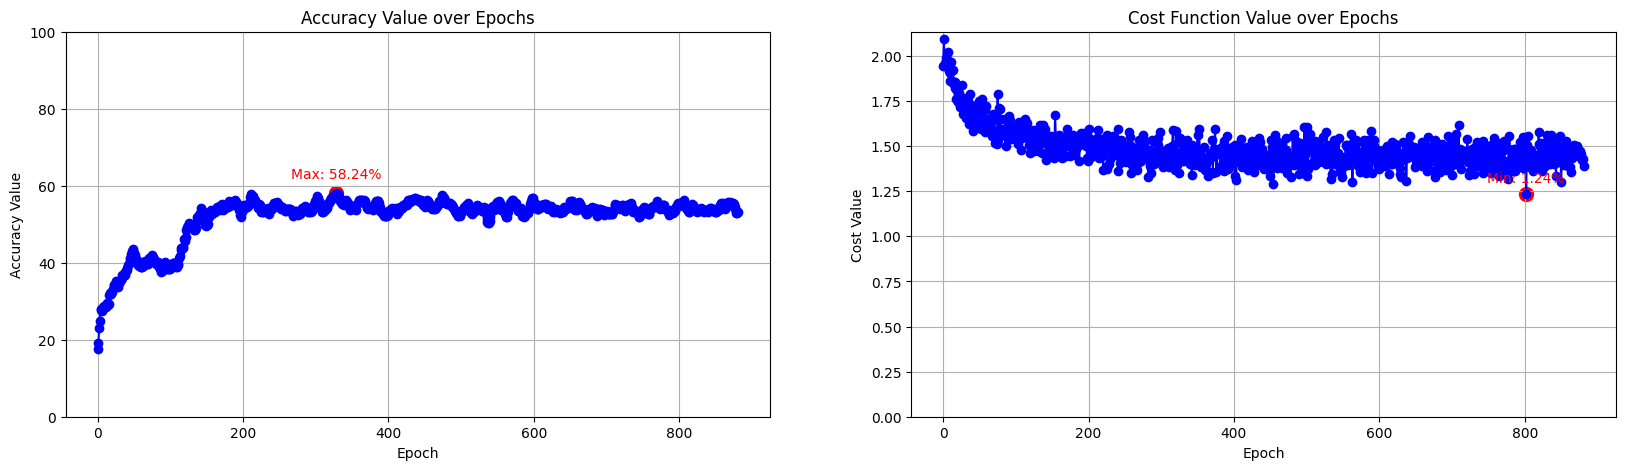

In [18]:
from Modules.Utils import plot_metrics_accuracy_and_cost
plot_metrics_accuracy_and_cost(all_accuracy,all_cost)

In [19]:
test_accuracy = accuracy(params,X_test,Y_test,circuit_MERA)

In [20]:
test_accuracy

55.083333333333336